
# <p style="text-align: center;">MIS 382N: ADVANCED PREDICTIVE MODELING - MSBA</p>
# <p style="text-align: center;">Assignment 5 - BONUS - SECTION-B (5.30pm to 7pm class)</p>
## <p style="text-align: center;">Points: 95, Bonus: 40 </p>
## <p style="text-align: center;">Due: November 30, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Your partner needs to be from the same section. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTEID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group. If you do change, let the TA know. 

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

### Name(s)
1. Matthew Leong
2. Chirag Ramesh

### My contribution:

I refined question 1's formatting and worked on the ensemble methods (4) and explored shapely values (part of 5).

# Question 1 : Bayesian Belief Networks (15 pts)

![Question 1](https://i.imgur.com/3ayVbFi.jpeg) 

All nodes are binary and can take 0/1 values

The probabilities are given below:

P(Bark = 1) = 0.05   
P(Rain = 1) = 0.01


P(Scared = 1 | Bark = 0, Rain = 0) = 0.001  
P(Scared = 1 | Bark = 0, Rain = 1) = 0.1  
P(Scared = 1 | Bark = 1, Rain = 0) = 0.8  
P(Scared = 1 | Bark = 1, Rain = 1) = 0.9  

P(Hides = 1 | Scared = 1) = 0.95  
P(Hides = 1 | Scared = 0) = 0.05  

For the given Bayesian network, Compute the following probabilities :  


**(a) (4 pts)** Find the probability that cat hides = 1.  
**(b) (4 pts)** Given that cat got scared (Scared = 1), what is the probability that it rained (Rain = 1)?  
**(c) (7 pts)** Given that cat got scared (Scared = 1) and the dog barked (Bark = 1), what is the probability that it rained (Rain = 1)?

Let B stand for bark, R for Rain, S for Scared, and H for Hides. Let ' signify a not ie B' is no Bark.

The general Bayesian model is:
$$
P(B,R,S,H) = P(B)*P(R)*P(S|B,R)*P(H|S)
$$

### a.

$$
P(H) = P(H|S)*P(S)+P(H|S')*P(S') \\
P(S) = P(S|B,R)*P(B,R) + P(S|B',R)*P(B',R) + P(S|B,R') * P(B,R') + P(S|B',R')*P(B',R') \\
 = 0.9 * (0.05*0.01) + 0.1*(0.95*0.01)+ 0.8*(0.05*0.99) + 0.001*(0.95*0.99) \\
 = 0.0419405 \\
P(S') = 0.9580595 \\
P(H) = 0.95*0.0419405 + 0.05*0.95840595 \\
= 0.0877637725 \\
\approx 0.088 \\
= 8.8\%
$$

### b.

The nonconditional probabilities are: 
$$
P(B') = 0.95 \\
P(B) = 0.05 \\
P(R') = 0.99 \\
P(R) = 0.01 \\
P(B',R) = 0.0095 \\
P(B,R') = 0.0495 \\
P(B,R) = 0.0005 \\
P(B',R') = 0.95 * 0.99 = 0.9405 \\
P(S,B',R') = 0.9405 * 0.001 = 0.0009405 \\
P(S,B',R) = 0.00095 \\
P(S,B,R') = 0.0396 \\
P(S,B,R) = 0.00045 \\
P(S) = 0.0009405 + 0.00045 + 0.0396 + 0.00095  = 0.0419405 \\
P(S') = 0.9580595 \\
$$

$$
P(R|S) = \frac{P(S,B',R)+P(S,B,R)}{P(S)} \\
= \frac{(0.00045 + 0.00095)}{0.0419405} \\
= 0.03338062254 \\
\approx 3.33\% \\
$$

### c.

$$
P(R|S,B) = \frac{P(S,B,R)}{P(S,B,R)+P(S,B,R')} \\
= \frac{0.00045}{0.00045 + 0.0396} \\
= 0.01123595505 \\
\approx 1.12\% \\
$$

# Question 2 - **Random Forest (30 pts)**  

The goal of this problem is to explore the effect of feature selection using  the following dataset (same as in HW 4) https://www.kaggle.com/wendykan/lending-club-loan-data

Since the dataset is really huge, we will use only a certain set of features and samples to build our model. We will also use only two classes instead of all.

The modified dataset with reduced number of samples has been prepared for your use. The file can be downloaded using the code below. You can also find it [here](https://drive.google.com/file/d/1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs/view?usp=sharing) in case you have a different environment and this code does not run.



In [1]:
%%bash
ggID='1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs'  
ggURL='https://drive.google.com/uc?export=download'  
filename="$(curl -sc /tmp/gcokie "${ggURL}&id=${ggID}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')"  
getcode="$(awk '/_warning_/ {print $NF}' /tmp/gcokie)"  

if [ -e "${filename}" ]; then
    echo 'File already exists'
else
    curl -Lb /tmp/gcokie "${ggURL}&confirm=${getcode}&id=${ggID}" -o "${filename}"  
fi

Couldn't find program: 'bash'


In [2]:
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('loan.csv')
df = dataset.fillna(0)

def LoanResult(status):
    if (status == 'Fully Paid') or (status == 'Current'):
        return 1
    else:
        return 0

df['loan_status'] = df['loan_status'].apply(LoanResult)

df = df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
             'emp_length', 'home_ownership','annual_inc', 'verification_status', 'loan_status',
             'purpose','addr_state', 'dti','open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
             'initial_list_status', 'recoveries','collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
             'application_type', 'tot_coll_amt', 'tot_cur_bal', 'avg_cur_bal', 'chargeoff_within_12_mths',
             'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag']]
df_cat = df.select_dtypes(exclude=['int64', 'float64'])
df = pd.get_dummies(df, df_cat.columns.values)
df.head()


C:\Users\mattl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,...,last_pymnt_d_Feb-2019,last_pymnt_d_Jan-2019,last_pymnt_d_Jul-2018,last_pymnt_d_Nov-2018,last_pymnt_d_Oct-2018,last_pymnt_d_Sep-2018,application_type_Individual,application_type_Joint App,debt_settlement_flag_N,debt_settlement_flag_Y
0,2500,2500,2500.0,13.56,84.92,55000.0,1,18.24,9.0,1.0,...,1,0,0,0,0,0,1,0,1,0
1,30000,30000,30000.0,18.94,777.23,90000.0,1,26.52,13.0,1.0,...,1,0,0,0,0,0,1,0,1,0
2,5000,5000,5000.0,17.97,180.69,59280.0,1,10.51,8.0,0.0,...,1,0,0,0,0,0,1,0,1,0
3,4000,4000,4000.0,18.94,146.51,92000.0,1,16.74,10.0,0.0,...,1,0,0,0,0,0,1,0,1,0
4,30000,30000,30000.0,16.14,731.78,57250.0,1,26.35,12.0,0.0,...,1,0,0,0,0,0,1,0,1,0


Select the `loan_status` column as the target column.  


**Part 1: (3 pts)** Split the dataset into train and test set with 25% data in test set and random_state = 42. Perform [Min-Max Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) on the dataset. Print the total number of features. 

**Part 2: (5 pts)** Use the dataset to create a `RandomForestClassifier(n_estimators=5, random_state=42)` model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to show the precision, recall and F1 score based on the test set.  

**Part 3: (6 pts)** Use [$\chi^2$ test](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to select the top 100, 30 and 10 features using [SelectKBest](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) module. Train a random forest model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for each of the trained models.  

**Note:** $\chi^2$ test requires non-negative values only for all features. Since we have performed Min-Max scaling previously (where the default behavior is to scale features between 0 and 1, there should not be any problem performing this test.)   

**Part 4: (6 pts)** [Plot the ROC curves](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/21_plot_roc_curve.ipynb) for all of the 4 models.  

**Part 5: (8 pts)** Plot the feature importance for each of the 4 random forest models that you have trained to show the top 5 features. ([Get feature names after feature selection](https://stackoverflow.com/a/43765224), [Plot feature importance using Pandas and matplotlib](https://stackoverflow.com/a/51520906))  

**Part 6: (2 pts)** What do you observe from the ROC curves?

# Solution

### Part 1

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

y = df['loan_status']
X = df.drop(['loan_status'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
min_max_scaler = preprocessing.MinMaxScaler()
X_trainscale = min_max_scaler.fit_transform(X_train)
X_testscale = min_max_scaler.fit_transform(X_test)
print('There are',X.shape[1], 'features')

There are 160 features


### Part 2


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=5, random_state=42)
clf.fit(X_trainscale, y_train)
print(classification_report(y_test, clf.predict(X_testscale)))

              precision    recall  f1-score   support

           0       0.64      0.38      0.47       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.81      0.69      0.73     56517
weighted avg       0.99      0.99      0.99     56517



### Part 3

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#we are using the slectbest module to select the top 100 features
X_train100 = SelectKBest(chi2, k=100).fit_transform(X_trainscale, y_train)
X_test100 = SelectKBest(chi2, k=100).fit_transform(X_testscale, y_test)

clf100 = RandomForestClassifier(n_estimators=5, random_state=42)
clf100.fit(X_train100, y_train)
print('Top 100',classification_report(y_test, clf100.predict(X_test100)))


Top 100               precision    recall  f1-score   support

           0       0.02      0.15      0.03       850
           1       0.99      0.86      0.92     55667

    accuracy                           0.85     56517
   macro avg       0.50      0.50      0.47     56517
weighted avg       0.97      0.85      0.90     56517



In [6]:
#we are using the slectbest module to select the top 30 features

X_train30 = SelectKBest(chi2, k=30).fit_transform(X_trainscale, y_train)
X_test30 = SelectKBest(chi2, k=30).fit_transform(X_testscale, y_test)

clf30 = RandomForestClassifier(n_estimators=5, random_state=42)
clf30.fit(X_train30, y_train)
print('Top 30',classification_report(y_test, clf30.predict(X_test30)))


Top 30               precision    recall  f1-score   support

           0       0.48      0.15      0.23       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.98     56517
   macro avg       0.73      0.57      0.61     56517
weighted avg       0.98      0.98      0.98     56517



In [7]:
#we are using the slectbest module to select the top 10 features

X_train10 = SelectKBest(chi2, k=10).fit_transform(X_trainscale, y_train)
X_test10 = SelectKBest(chi2, k=10).fit_transform(X_testscale, y_test)
clf10 = RandomForestClassifier(n_estimators=5, random_state=42)
clf10.fit(X_train10, y_train)
print('Top 10',classification_report(y_test, clf10.predict(X_test10)))

Top 10               precision    recall  f1-score   support

           0       1.00      0.07      0.14       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.99      0.54      0.56     56517
weighted avg       0.99      0.99      0.98     56517



### Part 4

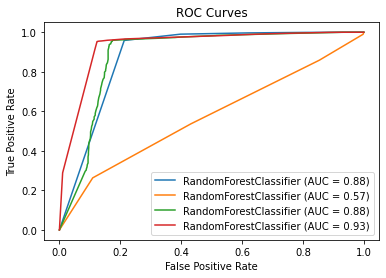

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

ax=plt.gca()
roc160 = plot_roc_curve(clf, X_testscale, y_test,ax=ax)
roc100 = plot_roc_curve(clf100, X_test100, y_test, ax=ax) #has lowest auc
roc30 = plot_roc_curve(clf30, X_test30, y_test, ax=ax)
roc10 = plot_roc_curve(clf10, X_test10, y_test, ax=ax) #has the highest auc
plt.title('ROC Curves')
plt.show()

### Part 5

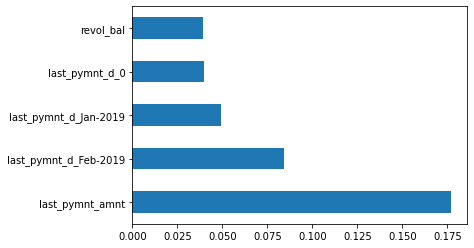

In [9]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()


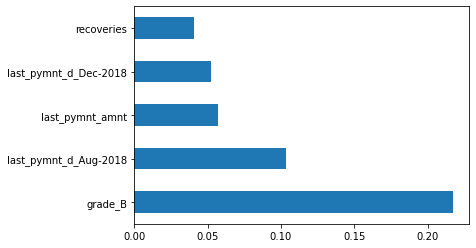

In [10]:
cols = SelectKBest(chi2, k=100).fit(X_testscale, y_test).get_support(indices=True)
features_df_new = X.iloc[:,cols]
feat_importances = pd.Series(clf100.feature_importances_, index=features_df_new.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()


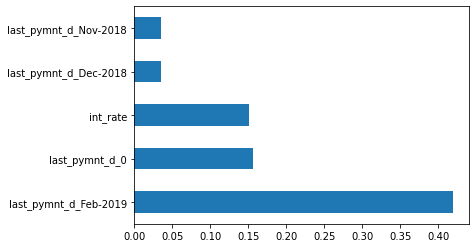

In [11]:
cols = SelectKBest(chi2, k=30).fit(X_testscale, y_test).get_support(indices=True)
features_df_new = X.iloc[:,cols]
feat_importances = pd.Series(clf30.feature_importances_, index=features_df_new.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()


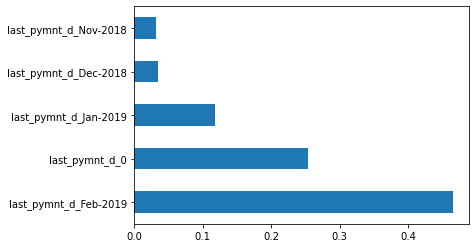

In [12]:
cols = SelectKBest(chi2, k=10).fit(X_testscale, y_test).get_support(indices=True)
features_df_new = X.iloc[:,cols]
feat_importances = pd.Series(clf10.feature_importances_, index=features_df_new.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

### Part 6

There are 3 models that have similar areas under the curve and the last model has a very low AUC value. 
In terms of the AUC values we can see that the last model with the top 10 features performs the best. I think the clf10 model performs the best because the SelectKBest algorithm reduces overfitting by getting rid of the irrelevant features.

# Question 3 : Logistic Regression with Regularization and Decision Tree (25 pts)

The goal of this problem is to explore the effect of regularization on logistic regression for binary classification, we will be using the diabetes dataset. 
This dataset is used to predict if a person is having 
diabetes based on feature variables including blood pressure, bmi, age etc. The target variable is stored in "outcome" column.

* Load the "diabetes.csv" and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42. 


* We need to use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on the original data, we use StandardScaler to center each feature. Also remember that when we have training and testing data, we fit preprocessing parameters on training data and apply them to all testing data. You should scale only the features (independent variables), not the target variable y. 

   Note: X should have 8 features.


**Part 1: (6 pts)** Fit a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with penalty $l2$
(Ridge Regularization) for the following values of regularization  C = $[0.0001,0.001,0.1,10,100]$ using the training data. Report the accuracy score on the test data averaged over 5 runs of the model for each of the C values. 

  Note : Smaller values of C indicate stronger regularization

    

**Part 2: (6 pts)** Fit a [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) classifier on the training data, and report the accuracy score on the test data averaged over 5 runs. Briefly explain which of the models performed the best Logistic Regression + regularization or Decision Tree Classifier and why. 


* Now, We will check if the decision boundary from logistic regression is linear by using a 2D plot.


**Part 3: (4 pts)** Select the top two most important features ([Feature importance](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)) using the training data with a Decision Tree Classifier and random_state = 10. Subset the train and test data to have only the selected features. This will be used as the training and test data for part $4$.


**Part 4: (8 pts)** Fit a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with penalty = $l2$, C = 10 (Ridge Regularization) and random state = 0 for the training data from part $3$ . Plot the decision boundary of the logistic regression model with the two features, as X and Y axis. Here is an [example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html) . Plot the scatter points for the test data, on the same graph showing the two classes as two different color. 

  * Hint : You can use the below limits for plotting the decision boundary, where $X[:,0]$ indicates feature 1 values and $X[:,1]$ indicates feature 2 values of the train dataset. 

     $ x_\min, x_\max = X[:, 0].min() - .5, X[:, 0].max() + .5 $ 

     $ y_\min, y_\max = X[:, 1].min() - .5, X[:, 1].max() + .5 $
   

# Solution

#### Loading dataset and pre-processing (**1 pt**)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

df = pd.read_csv('diabetes.csv')
df = df.fillna(0)
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_trainscale = StandardScaler().fit_transform(X_train)
X_testscale = StandardScaler().fit_transform(X_test)
print(X_trainscale.shape)
print(X_testscale.shape)

(514, 8)
(254, 8)


#### Part 1 (**6 pts**)

In [14]:
C = [0.0001,0.001,0.1,10,100] 

for number in C:
    count = 0
    value = 0
    for i in range(5):
        clf = LogisticRegression(C=number).fit(X_trainscale, y_train)
        print(f'For C={number} and run {i+1}:', clf.score(X_testscale, y_test))
        count = count + 1
        value = value + clf.score(X_testscale, y_test)
    print('Average score:', value / count)

For C=0.0001 and run 1: 0.6614173228346457
For C=0.0001 and run 2: 0.6614173228346457
For C=0.0001 and run 3: 0.6614173228346457
For C=0.0001 and run 4: 0.6614173228346457
For C=0.0001 and run 5: 0.6614173228346457
Average score: 0.6614173228346457
For C=0.001 and run 1: 0.6614173228346457
For C=0.001 and run 2: 0.6614173228346457
For C=0.001 and run 3: 0.6614173228346457
For C=0.001 and run 4: 0.6614173228346457
For C=0.001 and run 5: 0.6614173228346457
Average score: 0.6614173228346457
For C=0.1 and run 1: 0.7401574803149606
For C=0.1 and run 2: 0.7401574803149606
For C=0.1 and run 3: 0.7401574803149606
For C=0.1 and run 4: 0.7401574803149606
For C=0.1 and run 5: 0.7401574803149606
Average score: 0.7401574803149606
For C=10 and run 1: 0.7440944881889764
For C=10 and run 2: 0.7440944881889764
For C=10 and run 3: 0.7440944881889764
For C=10 and run 4: 0.7440944881889764
For C=10 and run 5: 0.7440944881889764
Average score: 0.7440944881889764
For C=100 and run 1: 0.7401574803149606
For 

#### Part 2 (**6 pts**)

In [15]:
from sklearn.tree import DecisionTreeClassifier

count = 0
value = 0
for i in range(5):
    dtc = DecisionTreeClassifier().fit(X_trainscale, y_train)
    count = count + 1
    print(count, dtc.score(X_testscale, y_test))
    value = value + dtc.score(X_testscale, y_test)
    avg = value / count
print(' The average score is ', avg)

1 0.7086614173228346
2 0.7165354330708661
3 0.7165354330708661
4 0.6968503937007874
5 0.7204724409448819
 The average score is  0.7118110236220472


When comparing the avg values we can see that when implementing logistic regression the C value of 10 gives us the highest score. I think logisitc regression is better becasue we are considering the possibility of overfitiing by implementing a penalty.

#### Part 3 (**4 pts**)

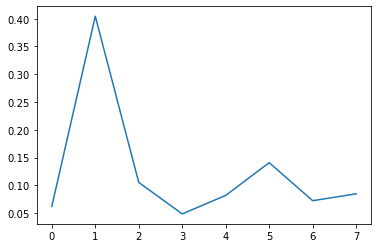

In [16]:
import matplotlib.pyplot as plt
dtc = DecisionTreeClassifier(random_state=10)
dtc.fit(X_trainscale,y_train)
dtc.feature_importances_
plt.plot(dtc.feature_importances_)
plt.show()

In [17]:
most_impval = pd.Series(DecisionTreeClassifier(random_state=10).fit(X_trainscale, y_train).feature_importances_)
most_impval_name = pd.Series(df.columns)
df_mainImp = pd.concat([most_impval_name, most_impval], axis=1)
df_mainImp = df_mainImp.iloc[:8,:]
print(df_mainImp.sort_values(by=[1],ascending=False)[0][:2])

1    Glucose
5        BMI
Name: 0, dtype: object


In [18]:
top_two = ['Glucose', 'BMI']
X_trainnew = pd.DataFrame(X_trainscale)[[1,5]]
X_testnew = pd.DataFrame(X_testscale)[[1,5]]

#### Part 4 (**8 pts**)

In [19]:
clf = LogisticRegression(random_state=0, C=10)
clf.fit(X_trainnew, y_train)
x_min, x_max = X_trainnew.loc[:, 1].min() - .5, X_trainnew.loc[:, 1].max() + .5
y_min, y_max = X_trainnew.loc[:, 5].min() - .5, X_trainnew.loc[:, 5].max() + .5
h = .02 
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

<ipython-input-20-6ad1862cfcca>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Log, cmap=plt.cm.Paired)


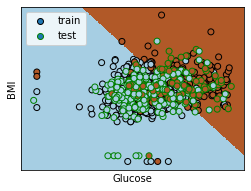

In [20]:
Log = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Log = Log.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Log, cmap=plt.cm.Paired)
plot_train = plt.scatter(X_trainnew.loc[:, 1], X_trainnew.loc[:, 5], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plot_test = plt.scatter(X_testnew.loc[:, 1], X_testnew.loc[:, 5], c=y_test, edgecolors='g', cmap=plt.cm.Paired)
plt.legend([plot_train, plot_test],['train','test'])
plt.xlabel('Glucose')
plt.ylabel('BMI')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

# Question 4 - Comparison of different ensembles method for classification (25 pts)

In this question, we will compare performance of different ensemble methods for classification problems: [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [GradientBoosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Classifiers.

[Spam Classification Data](https://archive.ics.uci.edu/ml/datasets/Spambase) of UCI will be used (you can use the data provided: 'spam_uci.csv'). Don't worry about column names. The last column represents target label, 1 if spam and zero otherwise.

* Load the data and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42. 



**Part 1: (4 pts)** Use a Decision Tree Classifier with random_state = 10 and Logistic Regression with random_state = 10 and solver ="lbfgs" for the spam classification problem. Report the accuracy_score and roc_auc_score on the test data for each classifier.


**Part 2: (8 pts)** Create an ensemble of 50 classifiers (i.e n_estimators = 50) with random_state = 10 for [bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with base classifier as Decision Tree Classifier and Logistic Regression from part $1$ . Report accuracy_score and roc_auc_score on the test data for both the Bagging classifiers. Compare the results and breifly explain the effect of using bagging for the spam classification problem for both the Logistic Regression and Decision Tree base classifier.


* Now we will look at the effect of other ensemble methods on this problem.


**Part 3: (5 pts)** Use a [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to classify whether an email is spam. Report your testing accuracy ([accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)) and [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score). You will need [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) for roc_auc_score. 


**Part 4: (5 pts)** Use [Gradient Boosting Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GBDT), and [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) for the spam classification problem.  Report  accuracy_score and roc_auc_score on the test data for each algorithm. 

  Note : For part 3 and 4 find the best values for the hyper parameters of each of the models by using GridSearchCV. 


**Part 5: (3 pts)** Briefly explain which of the three ensemble method above from Part 3&4 performed the best and why?


# Solution

#### Loading and pre-processing dataset

In [21]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [22]:
#Load in spam
spam = pd.read_csv('spam_uci.csv',index_col = 0)
spam_df = spam.copy()
spam_df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [23]:
#Seperate the features
X = spam_df.drop('57',1)
Y = spam_df['57']

#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

#### Part 1 (**4 pts**)

In [24]:
#Decision trees
decision_tree = tree.DecisionTreeClassifier(random_state = 10).fit(X_train,Y_train)

decision_treetepred = decision_tree.predict(X_test)
print("Testing Accuracy for random state 10 decision tree:", metrics.accuracy_score(Y_test,decision_treetepred))

print("The roc_auc_score is:", roc_auc_score(Y_test,decision_tree.predict_proba(X_test)[:,1]))

Testing Accuracy for random state 10 decision tree: 0.9117840684660962
The roc_auc_score is: 0.9085903594264297


In [25]:
#Logistic Regression
logistic = LogisticRegression(random_state=10,solver='lbfgs').fit(X_train, Y_train)

logistic_tepred = logistic.predict(X_test)
print("Testing Accuracy for logistic regression:", metrics.accuracy_score(Y_test,logistic_tepred))

print("The roc_auc_score is:", roc_auc_score(Y_test,logistic.predict_proba(X_test)[:,1]))

Testing Accuracy for logistic regression: 0.9223173140223832
The roc_auc_score is: 0.9660900295629042


#### Part 2 (**8 pts**)

In [26]:
#Bagging classifier for trees
dtbag = BaggingClassifier(base_estimator = decision_tree, n_estimators = 50, random_state = 10).fit(X_train,Y_train)

dtbag_tepred = dtbag.predict(X_test)
print("Testing accuracy for decision tree ensemble", metrics.accuracy_score(Y_test,dtbag_tepred))

print("The roc_auc_score is:", roc_auc_score(Y_test,dtbag.predict_proba(X_test)[:,1]))

Testing accuracy for decision tree ensemble 0.9447004608294931
The roc_auc_score is: 0.9813261583558889


In [27]:
#Bagging classifier for trees
logistic_bag = BaggingClassifier(base_estimator = logistic, n_estimators = 50, random_state = 10).fit(X_train,Y_train)

logistic_bag_tepred = logistic_bag.predict(X_test)
print("Testing accuracy for logistic regression ensemble", metrics.accuracy_score(Y_test,logistic_bag_tepred))

print("The roc_auc_score is:", roc_auc_score(Y_test,logistic_bag.predict_proba(X_test)[:,1]))

Testing accuracy for logistic regression ensemble 0.9262672811059908
The roc_auc_score is: 0.9696026303495839


When compared to non ensemble methods, the decision tree improved greatly while the logistic regression mostly remained the same with same slight improvements. This is due to the fact that ensemble relies on model variability or ambiguity in order to obtain a higher accuracy. Logistic regression models are going to be very similar while the decision tree model can vary a lot. As a result, the decision tree model benefits from the ensemble more than the logistic.

#### Part 3 (**5 pts**)

In [28]:
#Using grid search
params = {'n_estimators':[50,100,150,200],'max_depth':[5,10,15,20,None]}

rf_optimal_params = GridSearchCV(RandomForestClassifier(random_state=10), params)
rf_optimal_params.fit(X_train, Y_train)
rf_optimal_params.best_params_

{'max_depth': None, 'n_estimators': 150}

In [29]:
#Random Forest
random_forest = RandomForestClassifier(random_state = 10, 
                                       max_depth = rf_optimal_params.best_params_['max_depth'],
                                       n_estimators = rf_optimal_params.best_params_['n_estimators']).fit(X_train,Y_train)

random_forest_tepred = random_forest.predict(X_test)
print("Testing accuracy for random forest", metrics.accuracy_score(Y_test,random_forest_tepred))

print("The roc_auc_score is:", roc_auc_score(Y_test,random_forest.predict_proba(X_test)[:,1]))

Testing accuracy for random forest 0.9598420013166556
The roc_auc_score is: 0.9879439338989155


#### Part 4 (**5 pts**)

In [30]:
#Using grid search
params = {'n_estimators':[50,100,150,200],'max_depth':[5,10,15,20,None]}

gb_optimal_params = GridSearchCV(GradientBoostingClassifier(random_state=10), params)
gb_optimal_params.fit(X_train, Y_train)
gb_optimal_params.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [31]:
#Gradient Boost
gradient_boost = GradientBoostingClassifier(random_state = 10, 
                                       max_depth = gb_optimal_params.best_params_['max_depth'],
                                       n_estimators = gb_optimal_params.best_params_['n_estimators']).fit(X_train,Y_train)

gradient_boost_tepred = gradient_boost.predict(X_test)
print("Testing accuracy for gradient boost", metrics.accuracy_score(Y_test,gradient_boost_tepred))

print("The roc_auc_score is:", roc_auc_score(Y_test,gradient_boost.predict_proba(X_test)[:,1]))

Testing accuracy for gradient boost 0.955892034233048
The roc_auc_score is: 0.989394441888745


In [32]:
ada_params = {'n_estimators':[50,100,150,200], 'learning_rate':[.01,.05,0.1,0.5]}

ada_optimal_params = GridSearchCV(AdaBoostClassifier(random_state=10), ada_params)
ada_optimal_params.fit(X_train, Y_train)
ada_optimal_params.best_params_

{'learning_rate': 0.5, 'n_estimators': 100}

In [33]:
#Ada Boost
ada_boost = AdaBoostClassifier(random_state = 10, 
                                       learning_rate = ada_optimal_params.best_params_['learning_rate'],
                                       n_estimators = ada_optimal_params.best_params_['n_estimators']).fit(X_train,Y_train)

ada_boost_tepred = ada_boost.predict(X_test)
print("Testing accuracy for gradient boost", metrics.accuracy_score(Y_test,ada_boost_tepred))

print("The roc_auc_score is:", roc_auc_score(Y_test,ada_boost.predict_proba(X_test)[:,1]))

Testing accuracy for gradient boost 0.9440421329822252
The roc_auc_score is: 0.9828087611752414


#### Part 5 (**3 pts**)

Selecting the best model depends on what criteria one wnats. Under a testing score criteria, random forests wins out. However, this does not take into account complexity and ease of interpretation. In that regard, ada boosting wins out as it does not sacrifice much accuracy or the roc_auc_score and has a very simplistic interpretation of stumps with the lowest number of stumps involved. As for gradient boosting, it wins only under a compromise scenario which is to be able to run a fairly but not too complex model with a good accuracy score. We would personally settle for adaboost as it's the lowest complexity here and still boasts a pretty good accuracy score.


# Question 5 (Bonus): Segmenting Customers for Predicting Credit Card Fraud (40 points)

In this question, we will look at a technique to segment customers using SHAP (SHapley Additive exPlanations). Please read this article to learn about SHAP - https://christophm.github.io/interpretable-ml-book/shap.html.

SHAP values provide an explanation for each observation in terms of feature attribution (which features were most influential in determining the predicted value for that observation).

For some applications, that may be too fine a resolution, and one would rather identify subsets of observations (called segments or clusters) for which the “explanations are similar”, Moreover, it helps if subsets are also “understandable”, i.e. easy to describe in terms of the feature values. Then the subsets become “actionable”, as one can design specific interventions (e.g. targeted marketing messages) for each subset.

The goal of this problem is to identify such segments, and see if the variation of SHAP values within each segment is indeed lower than the variation in the total population. We will proceed as follows:

1. First, we will fit an XGBoost model to perform the classification task.
2. We will then use the shap.TreeExplainer which uses Tree SHAP algorithms and estimate the SHAP values for each observation.
3. Our objective is to segment customers into groups which have low variance in the SHAP values - these represent segments of similar customers in the “feature attribution based explanation” space. We will do this as follows:  

    a. Cluster the SHAP values using KMeans clustering. You pick K, perhaps somewhere between 10 and 20.  
    b. Build a decision tree with the Cluster numbers as the labels. Specify the number of leaves to be in the range of [K, 2K].  Due to the choice of the surrogate class labels provided by the clustering, the   leaves of the decision tree will be encouraged to have similar SHAP values. Moreover, since you are learning a decision tree, these leaves are also simple to describe as rules. A good solution will be indicated if  for each of these leaves,  the variance of SHAP values of observations mapped to that leaf will be lower than the  overall variance.  


In [34]:
#LOADING DATA -  DONOT CHANGE

import re
import pandas as pd
import numpy as np
import shap
import time
import xgboost
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('credit.csv')

X = df
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

X = X.drop(['Class'], axis=1)
Y = df['Class']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=42)

### 5.1. Fit an XGBoost model on the train data and report the ROCAUC on the test set. (5pts)
### 5.2. Compute the SHAP values using the [TreeExplainer](https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html) and plot the [summary plot](https://shap.readthedocs.io/en/latest/generated/shap.summary_plot.html). Explain what the summary plot represents. (5 pts)
### 5.3. Perform KMeans clustering on the SHAP values inot $k$ clusters. Then, train a decision tree (with maximum depth $d$) to predict the cluster number obtained through KMeans -  the cluster numbers as the target. Visualize the decison tree (5 pts). Plot the variance of the SHAP values of the samples in each of the leaves - show that all these varinces is less than the overall variance of the SHAP values. The main parameters to tune here are the number of cluster $k$ and the maximum depth $d$. **(30 pts)**

### 5.1

In [35]:
xg_model = xgboost.XGBClassifier()
xg_model.fit(X_train_val,y_train_val)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
print("The roc_auc_score is:", roc_auc_score(y_test,xg_model.predict_proba(X_test)[:,1]))

The roc_auc_score is: 0.9253420278736734


### 5.2

In [37]:
explainer = shap.TreeExplainer(xg_model)

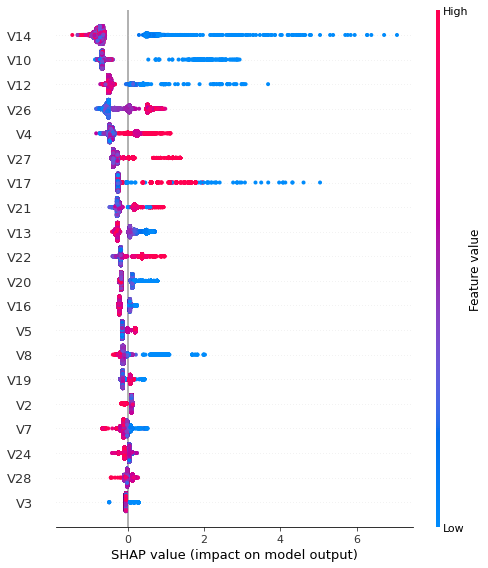

In [38]:
explainer = shap.TreeExplainer(xg_model)
shap_values = explainer.shap_values(X_train_val)
shap.summary_plot(shap_values, X_train_val)

The summary plot showcases the most important features and also showcases how each feature affects the model. For instance, V14 is quite important for the model and low values of V14 tend to reduce the odds of picking the class.

### 5.3

In [39]:
import pylab as pl

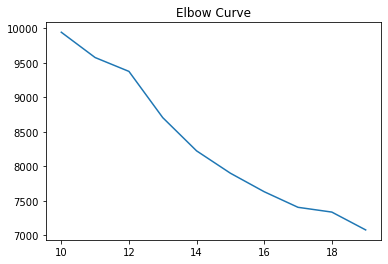

In [40]:
#convert shap_values array to dataframe
s = pd.DataFrame(shap_values, columns = X_train_val.columns)
#Use Elbow method to decide the optimal number of clusters
sse = []
for k in range(10,20):
    kmeans = KMeans(n_clusters = k)
    #fit the k-means model on the shap values
    kmeans.fit(s)
    #append the error of each iteration
    sse.append(kmeans.inertia_)
   
pl.plot(range(10,20), sse)
pl.title("Elbow Curve")
pl.show()

It seems like there isn't really an easy super stable linear one here. However, k=16 seems to be the closest and thus I will use that for my Kmeans clustering.

Not enough time to do the rest.